# 一、概述
试图只通过EDA和数据可视化来得到一个较好的预测结果。  
  
一般验证特征是否有效，都需要去实际扔进模型里跑一遍看看结果，但是这次的分类问题有个取巧的地方，可以直接通过原始准确率来判断。  
  
原理是：  
分类模型一般用树模型，而树模型的本质一般都是根据特征去不停的划分节点和分枝；  
且最简单的树模型是直接根据准确率去划分的；  
所以只要你构造的特征，可以让准确率提升，那么你的特征就是有效的  
  
比如Titanic train数据及中，原始存活率是0.3838，即你随便盲猜，准确的概率也有0.3838.  
如果你能挖掘出存活率大于0.3838的特征或信息，那基本就是有效的。  
所以要做的就是，以0.3838为基准，不停的去挖掘特征，超过这个数值。  
  
根据这个思路，如果挖掘的好，甚至完全可以自行写出一些规则，然后就可以得到不错的效果。  
比如 if Plcass=1 and Sex=female then survived = 1, 这一条准确率就可以达到90%以上的准确率
  
最后，可视化和EDA技术本身只是手段，重要的从中提取有效信息。

# 二、基础处理
处理文本  
缺失值暂不做处理，当做特殊一类

In [1]:
# 导入包
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.preprocessing import LabelEncoder


# 不用print，直接显示结果
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 显示所有列
pd.set_option('display.max_columns', 600)



In [2]:
# 读取数据
train = pd.read_csv('./Titanic data/train.csv')
test = pd.read_csv('./Titanic data/test.csv')

原始准确率为 0.3838  
Age和Cabin和Embarked有缺失值，Cabin缺失值严重  
Name和Sex和Ticket和Cabin和Embarked是文本型的，需要转成数值

In [3]:
train['Survived'].sum() / train['Survived'].count()

train.info()
train.head()

test.info()
test.head()

0.3838383838383838

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
# 处理文本数据
## Sex 两类，直接转成0-1变量
train['Sex'].value_counts()
train['Sex_num'] = train['Sex'].replace(['male','female'],[0,1])

male      577
female    314
Name: Sex, dtype: int64

In [5]:
## ticket
# 票号可能是随机的，数量和种类过于分散
# 或者有某种规律，但是我们这边暂时挖掘不到
# 我们认为票的费用更重要些，所以删除ticket这个特征
train['Ticket'].value_counts()
train.drop(['Ticket'], axis=1,inplace=True)

CA. 2343    7
347082      7
1601        7
347088      6
3101295     6
           ..
343095      1
370372      1
36866       1
PC 17475    1
349223      1
Name: Ticket, Length: 681, dtype: int64

In [6]:
## Cabin
# cabin有147个分类，且每个分类数量其实都不多，猜测这个是每个人/家庭 入住的具体的房间号
# 尝试提取第一个英文字母，再转成数字或onehot
train['Cabin'].value_counts()
train['Cabin_num'] = train['Cabin'].astype(str).str[0]
train['Cabin_num'].value_counts() # 其中n为缺失值

#X_train.groupby(['Cabin'])['Survived'].mean()


G6             4
B96 B98        4
C23 C25 C27    4
F33            3
C22 C26        3
              ..
A24            1
A5             1
E34            1
C47            1
A10            1
Name: Cabin, Length: 147, dtype: int64

n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin_num, dtype: int64

In [7]:
# name
# 提取称呼
train['Name'].value_counts()
train['Title'] = train.Name.str.extract('([A-Za-z]+)\.', expand=False)
train['Title'].value_counts()

# 统一称呼
title_Dict = {}
title_Dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
title_Dict.update(dict.fromkeys(['Jonkheer', 'Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
title_Dict.update(dict.fromkeys(['Mr'], 'Mr'))
title_Dict.update(dict.fromkeys(['Master'], 'Master'))

train['Title'] = train['Title'].map(title_Dict)
train['Title'].value_counts() # 最后剩下6类

# 转化为数字
train['Title_num'] = train['Title'].map({'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Officer': 5, 'Royalty': 6})
train['Title_num'].value_counts() 

Balkic, Mr. Cerin               1
Lemore, Mrs. (Amelia Milley)    1
Lievens, Mr. Rene Aime          1
Slabenoff, Mr. Petco            1
Nakid, Miss. Maria ("Mary")     1
                               ..
Olsen, Mr. Henry Margido        1
Kink, Mr. Vincenz               1
Jenkin, Mr. Stephen Curnow      1
Baumann, Mr. John D             1
Meyer, Mr. Edgar Joseph         1
Name: Name, Length: 891, dtype: int64

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Col           2
Major         2
Countess      1
Lady          1
Sir           1
Jonkheer      1
Don           1
Ms            1
Mme           1
Capt          1
Name: Title, dtype: int64

Mr         517
Miss       184
Mrs        127
Master      40
Officer     18
Royalty      4
Name: Title, dtype: int64

1.0    517
2.0    184
3.0    127
4.0     40
5.0     18
6.0      4
Name: Title_num, dtype: int64

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
 11  Sex_num      891 non-null    int64  
 12  Cabin_num    891 non-null    object 
 13  Title        890 non-null    object 
 14  Title_num    890 non-null    float64
dtypes: float64(3), int64(6), object(6)
memory usage: 104.5+ KB


# 三、数据探索-单变量
基准存活率为38.4%
  
PassengerId为唯一值，无效  
除了fare和age算是连续变量；其他都可以归为分类变量。  
仅从一些数值分布来看SibSp和Parch还是很有相关性的，0和1占大头。

<AxesSubplot:ylabel='Survived'>

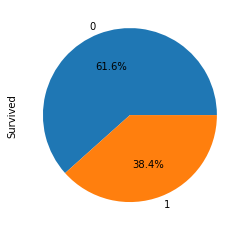

In [9]:
train['Survived'].value_counts().plot.pie(autopct='%1.1f%%')

In [10]:
# 查看其他变量的情况
columns = ['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp','Parch', 'Fare', 'Embarked', 'Cabin_num', 'Title']
for feat in columns:
    print(feat + "'s value:")
    train[feat].value_counts()

PassengerId's value:


891    1
293    1
304    1
303    1
302    1
      ..
591    1
590    1
589    1
588    1
1      1
Name: PassengerId, Length: 891, dtype: int64

Pclass's value:


3    491
1    216
2    184
Name: Pclass, dtype: int64

Sex's value:


male      577
female    314
Name: Sex, dtype: int64

Age's value:


24.00    30
22.00    27
18.00    26
19.00    25
30.00    25
         ..
55.50     1
70.50     1
66.00     1
23.50     1
0.42      1
Name: Age, Length: 88, dtype: int64

SibSp's value:


0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

Parch's value:


0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

Fare's value:


8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
8.4583      1
9.8375      1
8.3625      1
14.1083     1
17.4000     1
Name: Fare, Length: 248, dtype: int64

Embarked's value:


S    644
C    168
Q     77
Name: Embarked, dtype: int64

Cabin_num's value:


n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin_num, dtype: int64

Title's value:


Mr         517
Miss       184
Mrs        127
Master      40
Officer     18
Royalty      4
Name: Title, dtype: int64

# 四、数据探索-多变量交互
上面的单变量只是看个大概，最重要的还是将其他变量和目标变量Survived结合起来看。  
除了fare和age算是连续变量；其他都可以归为分类变量。   
多变量的交互，有事可以相互验证得到一些结论，比如法国登船的乘客存活率高，是因为其头等舱所占比例更高  

记住基准准确率：38.4%

In [11]:
# 总体分布函数
def TotalDistribution(x,title='indoor'):
    sns.set()                                   #设置seaborn默认格式
    plt.rcParams['axes.unicode_minus']=False      #显示负号

    plt.rcParams['figure.figsize'] = (13, 5)    #设定图片大小
    f = plt.figure()                            #确定画布

    f.add_subplot(1,2,1)
    sns.distplot(x, kde=False)                 #绘制频数直方图
    plt.ylabel("Frequency", fontsize=16)
    plt.xticks(fontsize=16)                    #设置x轴刻度值的字体大小
    plt.yticks(fontsize=16)                   #设置y轴刻度值的字体大小
    plt.title(title + " (a)", fontsize=20)             #设置子图标题

    f.add_subplot(1,2,2)
    sns.distplot(x)                           #绘制密度直方图
    plt.ylabel("Density", fontsize=16)
    plt.xticks(fontsize=16)                  #设置x轴刻度值的字体大小
    plt.yticks(fontsize=16)                  #设置y轴刻度值的字体大小
    plt.title(title + " (b)", fontsize=20)            #设置子图标题

    plt.subplots_adjust(wspace=0.3)         #调整两幅子图的间距
    plt.show()

## 1. Sex VS Survived
女性的存活率为74.2%，远高于男性；  
且高于基准准确率，38.4%  
有效特征  

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

Sex     Survived
female  0           0.257962
        1           0.742038
male    0           0.811092
        1           0.188908
Name: Survived, dtype: float64

<AxesSubplot:xlabel='Sex'>

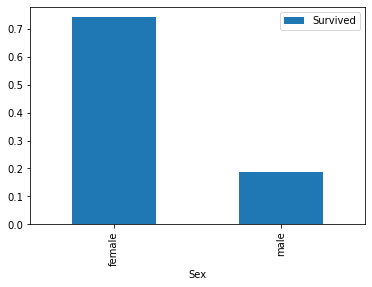

In [12]:
train.groupby(['Sex','Survived'])['Survived'].count()
train.groupby(['Sex','Survived'])['Survived'].count() / train.groupby(['Sex'])['Survived'].count()
train[['Sex','Survived']].groupby(['Sex']).mean().plot.bar()

## 2. Pclass  VS Survived
基准 = 38.4%  
Pclass=1 的存活率为62.9%  
所以可以预期，Pclass转为onehot后，1和2的效果应该不错

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


<AxesSubplot:xlabel='Pclass'>

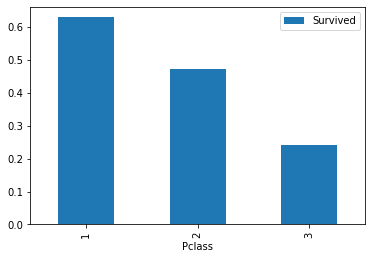

In [13]:
train[['Pclass','Survived']].groupby(['Pclass']).mean()
train[['Pclass','Survived']].groupby(['Pclass']).mean().plot.bar()


## 3. Sex，Pclass VS Survived
基准 = 38.4%  
Plcass和Sex的效果显著，女性在1和2等级的存活率超过了90%！  
在对性别分析的时候，本来男性的存活率只有18.8%, 但是在一等舱，男性的存活率翻倍了  
所以完全可以基于这个去构造特征，将Pclass和Sex结合取6个值，然后onehot

Survived          
                 count      mean
Pclass Sex                      
1      female       94  0.968085
       male        122  0.368852
2      female       76  0.921053
       male        108  0.157407
3      female      144  0.500000
       male        347  0.135447

<AxesSubplot:xlabel='Pclass,Sex'>

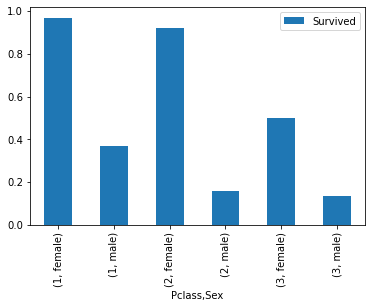

In [14]:
train[['Sex','Pclass','Survived']].groupby(['Pclass','Sex']).agg({'mean', 'count'})
train[['Sex','Pclass','Survived']].groupby(['Pclass','Sex']).mean().plot.bar()

## 4. Age VS Survived
基准 = 38.4%  
突出幼儿组和老年组    
按最后的分组情况除了15-25这个区间达不到基准，其他的都可以达到基准水平的  
  
需要说明的是，并不存在一步到位完美的分箱方法，只能是自己不断的尝试，即使在下面看上去不错的结果，这也只是单独看Age，弄不好和其他特征结合起来就有更好的分类方式了，所以需要不停的尝试  

In [15]:
# Age是连续变量，所以需要分箱，可以尝试不同的分箱方法

# 方案一 平均分成5组
# 效果尚可 三个分组超过基准了
# 额外提一句，这里老年组64-80，存活率只有0.09，可以逆向推
train['AgeBand'] = pd.cut(train['Age'], 5) # labels = ['1','2','3','4','5']
train[['AgeBand','Survived']].groupby(['AgeBand']).agg({'mean', 'count'})

# 方案二 人为指定区间 [0,5,15,30,50,80]
# 幼儿组 0-5 效果较为明显
train['AgeBand'] = pd.cut(train['Age'],[0,5,15,30,50,80])
train[['AgeBand','Survived']].groupby(['AgeBand']).agg({'mean', 'count'})

# 方案三 按分位数指定
# 效果不是很好，和方案一类似
train['AgeBand'] = pd.qcut(train['Age'],[0,0.1,0.3,0.5,0.7,0.9,1])
train[['AgeBand','Survived']].groupby(['AgeBand']).agg({'mean', 'count'})

# 方案四 结合以上方案和现实情况
train['AgeBand'] = pd.cut(train['Age'],[0,6,15,25,30,60,63,80])
train[['AgeBand','Survived']].groupby(['AgeBand']).agg({'mean', 'count'})

Survived          
                    count      mean
AgeBand                            
(0.34, 16.336]        100  0.550000
(16.336, 32.252]      346  0.369942
(32.252, 48.168]      188  0.404255
(48.168, 64.084]       69  0.434783
(64.084, 80.0]         11  0.090909

Survived          
            count      mean
AgeBand                    
(0, 5]         44  0.704545
(5, 15]        39  0.461538
(15, 30]      326  0.358896
(30, 50]      241  0.423237
(50, 80]       64  0.343750

Survived          
                 count      mean
AgeBand                         
(0.419, 14.0]       77  0.584416
(14.0, 22.0]       154  0.344156
(22.0, 28.0]       131  0.381679
(28.0, 36.0]       157  0.445860
(36.0, 50.0]       131  0.381679
(50.0, 80.0]        64  0.343750

Survived          
            count      mean
AgeBand                    
(0, 6]         47  0.702128
(6, 15]        36  0.444444
(15, 25]      218  0.344037
(25, 30]      108  0.388889
(30, 60]      283  0.420495
(60, 63]        9  0.444444
(63, 80]       13  0.076923

## 5.Sex Age VS Survived
基准 = 38.4%
看起来效果还不错，可以做一个很好的区分，女性远超基准线，男性可以做逆推  
  
P.S. 其中有个100%的，（60,63] female，虽然结果不错，但是心里要有数，数量太少，才3个，有可能过拟合，在test中不是这个情况了。  

Survived          
                   count      mean
AgeBand  Sex                      
(0, 6]   female       23  0.739130
         male         24  0.666667
(6, 15]  female       20  0.550000
         male         16  0.312500
(15, 25] female       79  0.746835
         male        139  0.115108
(25, 30] female       36  0.750000
         male         72  0.208333
(30, 60] female      100  0.800000
         male        183  0.213115
(60, 63] female        3  1.000000
         male          6  0.166667
(63, 80] female        0       NaN
         male         13  0.076923

<AxesSubplot:xlabel='AgeBand,Sex'>

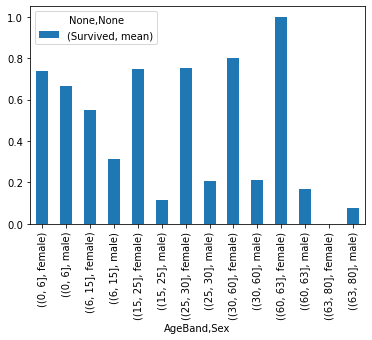

In [16]:
train[['Sex','AgeBand','Survived']].groupby(['AgeBand','Sex']).agg({'mean', 'count'})
train[['Sex','AgeBand','Survived']].groupby(['AgeBand','Sex']).agg({'mean'}).plot.bar()


## 6. Pclass Age VS Survived
基准 = 38.4%  
效果还可以  

Survived          
                   count      mean
AgeBand  Pclass                   
(0, 6]   1             3  0.666667
         2            14  1.000000
         3            30  0.566667
(6, 15]  1             3  1.000000
         2             5  1.000000
         3            28  0.285714
(15, 25] 1            36  0.777778
         2            46  0.413043
         3           136  0.205882
(25, 30] 1            19  0.684211
         2            31  0.419355
         3            58  0.275862
(30, 60] 1           111  0.657658
         2            74  0.418919
         3            98  0.153061
(60, 63] 1             6  0.333333
         2             1  1.000000
         3             2  0.500000
(63, 80] 1             8  0.125000
         2             2  0.000000
         3             3  0.000000

<AxesSubplot:xlabel='AgeBand,Pclass'>

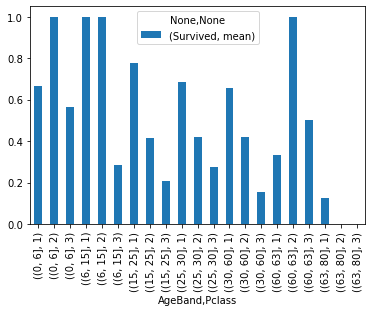

In [17]:
train[['Pclass','AgeBand','Survived']].groupby(['AgeBand','Pclass']).agg({'mean', 'count'})
train[['Pclass','AgeBand','Survived']].groupby(['AgeBand','Pclass']).agg({'mean'}).plot.bar()

## 7. Pclass Age Sex VS Survived
效果确实不错，但是这样的话，可能数据太分散，导致过拟合的情况发生

Survived          
                          count      mean
AgeBand  Sex    Pclass                   
(0, 6]   female 1             1  0.000000
                2             6  1.000000
                3            16  0.687500
         male   1             2  1.000000
                2             8  1.000000
                3            14  0.428571
(6, 15]  female 1             2  1.000000
                2             4  1.000000
                3            14  0.357143
         male   1             1  1.000000
                2             1  1.000000
                3            14  0.214286
(15, 25] female 1            25  0.960000
                2            19  0.947368
                3            35  0.485714
         male   1            11  0.363636
                2            27  0.037037
                3           101  0.108911
(25, 30] female 1             7  1.000000
                2            15  0.866667
                3            14  0.500000
         male   1            12  0.500000
                2            16  0.000000
                3            44  0.204545
(30, 60] female 1            48  0.979167
                2            30  0.900000
                3            22  0.272727
         male   1            63  0.412698
                2            44  0.090909
                3            76  0.118421
(60, 63] female 1             2  1.000000
                2             0       NaN
                3             1  1.000000
         male   1             4  0.000000
                2             1  1.000000
                3             1  0.000000
(63, 80] female 1             0       NaN
                2             0       NaN
                3             0       NaN
         male   1             8  0.125000
                2             2  0.000000
                3             3  0.000000

<AxesSubplot:xlabel='AgeBand,Sex,Pclass'>

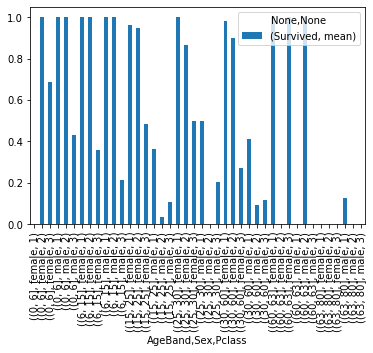

In [18]:
train[['Pclass','AgeBand','Sex','Survived']].groupby(['AgeBand','Sex','Pclass']).agg({'mean', 'count'})
train[['Pclass','AgeBand','Sex','Survived']].groupby(['AgeBand','Sex','Pclass']).agg({'mean'}).plot.bar()

## 8. SibSp VS Survived
基准 = 38.4%  
SibSp为1和2的存活率高，可以解读为乘客同行的同辈数量适中时生存率较高，没有和太多都不行   
这里可以尝试分组，也可以直接归为，两类，1和2为一类，其他为一类。

Survived          
         count      mean
SibSp                   
0          608  0.345395
1          209  0.535885
2           28  0.464286
3           16  0.250000
4           18  0.166667
5            5  0.000000
8            7  0.000000

<AxesSubplot:xlabel='SibSp'>

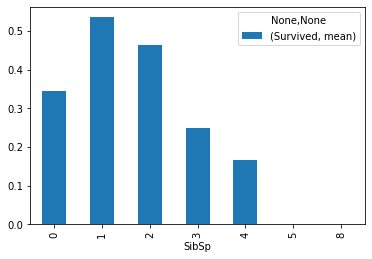

Survived          
             count      mean
SibSpBand                   
(-1, 0]        608  0.345395
(0, 2]         237  0.527426
(2, 8]          46  0.152174

<AxesSubplot:xlabel='SibSpBand'>

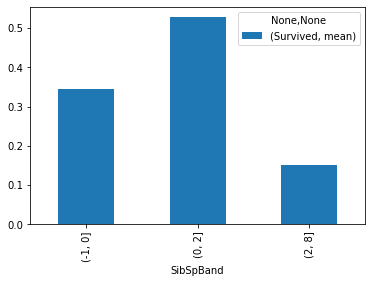

Survived          
             count      mean
SibSpBand                   
0              682  0.337243
1              209  0.535885

<AxesSubplot:xlabel='SibSpBand'>

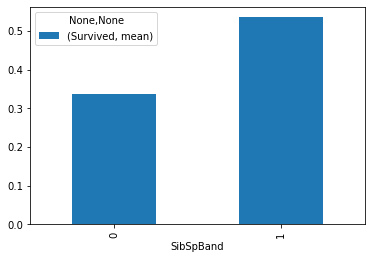

In [19]:
train[['SibSp','Survived']].groupby(['SibSp']).agg({'mean', 'count'})
train[['SibSp','Survived']].groupby(['SibSp']).agg({'mean'}).plot.bar()
plt.show()

# 试试分组
train['SibSpBand'] = pd.cut(train['SibSp'],[-1,0,2,8])
train[['SibSpBand','Survived']].groupby(['SibSpBand']).agg({'mean', 'count'})
train[['SibSpBand','Survived']].groupby(['SibSpBand']).agg({'mean'}).plot.bar()
plt.show()

# 分两类
train['SibSpBand'] = train['SibSp'].map({0: 0, 1: 1, 2: 1, 2: 0, 3: 0, 4: 0,5: 0,8: 0})
train[['SibSpBand','Survived']].groupby(['SibSpBand']).agg({'mean', 'count'})
train[['SibSpBand','Survived']].groupby(['SibSpBand']).agg({'mean'}).plot.bar()
plt.show()

## 9. Parch VS Survived
基准 = 38.4%
基本和SibSp类似，同行中父母子女数量适中存活率高。  
依然分组处理, 其中一类准确率有53%

<AxesSubplot:>

<AxesSubplot:xlabel='Parch', ylabel='Survived'>

<AxesSubplot:>

<AxesSubplot:xlabel='SibSp', ylabel='Survived'>

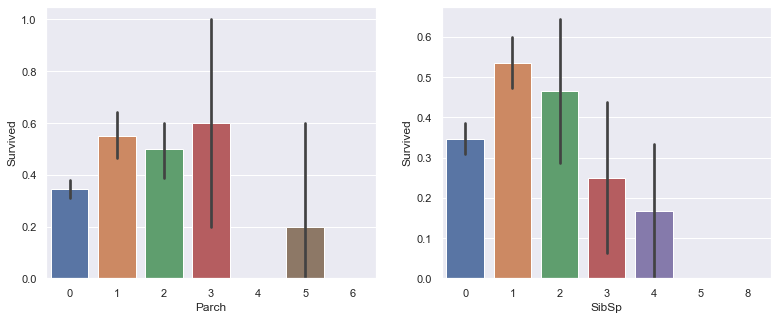

In [20]:
sns.set() 
plt.rcParams['figure.figsize'] = (13, 5)
f = plt.figure() 
f.add_subplot(1,2,1)
sns.barplot(data=train,x='Parch',y='Survived')
f.add_subplot(1,2,2)
sns.barplot(data=train,x='SibSp',y='Survived')

Survived          
         count      mean
Parch                   
0          678  0.343658
1          118  0.550847
2           80  0.500000
3            5  0.600000
4            4  0.000000
5            5  0.200000
6            1  0.000000

<AxesSubplot:xlabel='Parch'>

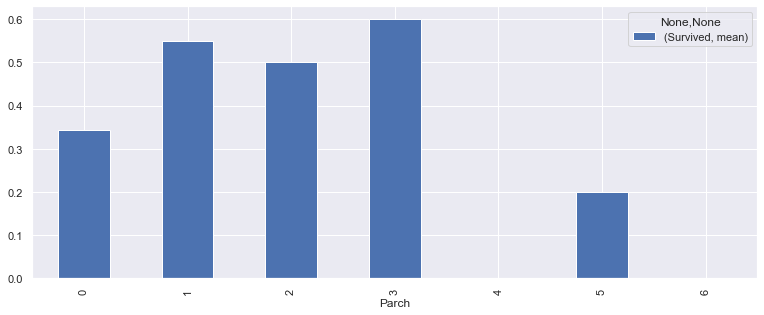

C:\Users\never\Miniconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Survived          
             count      mean
ParchBand                   
0              688  0.340116
1              203  0.532020

<AxesSubplot:xlabel='ParchBand'>

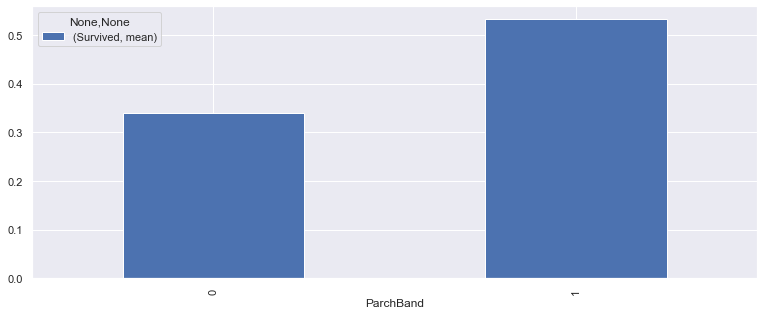

In [21]:
train[['Parch','Survived']].groupby(['Parch']).agg({'mean', 'count'})
train[['Parch','Survived']].groupby(['Parch']).agg({'mean'}).plot.bar()
plt.show()
# 分组
train['ParchBand'] = 0
train['ParchBand'][(train['Parch'] == 1) | (train['Parch'] == 2)|(train['Parch'] == 3)] = 1
train[['ParchBand','Survived']].groupby(['ParchBand']).agg({'mean', 'count'})
train[['ParchBand','Survived']].groupby(['ParchBand']).agg({'mean'}).plot.bar()
plt.show()

## 10. Fare VS Survived
大多数票价都是100以下  
票价在大约18以下时，存活率较低  
分组效果还可以(40.0, 50.0]	和(-1.0, 10.0]很低，其他都超过了基线  
分布偏态，取对数处理  

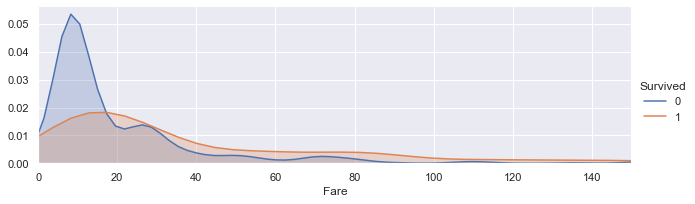

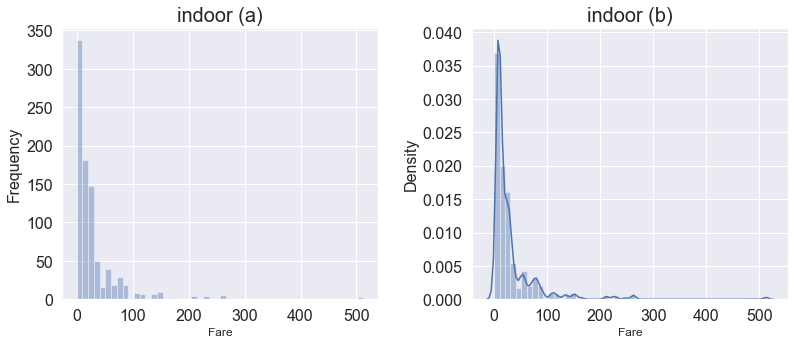

In [22]:
# 查看整体分布
# 分布左偏， 单纯从数值本身来说，做好对其取对数处理
FareFacet=sns.FacetGrid(train,hue='Survived',aspect=3)
FareFacet.map(sns.kdeplot,'Fare',shade=True)
FareFacet.set(xlim=(0,150))
FareFacet.add_legend()

TotalDistribution(train['Fare'])

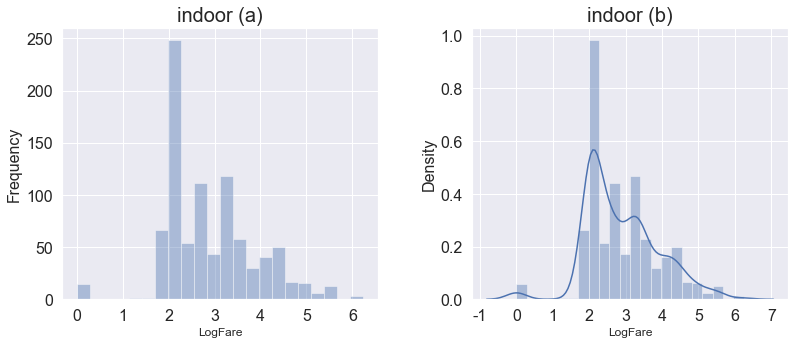

In [23]:
# 取对数处理
train['LogFare']=train['Fare'].map(lambda x: np.log(x) if x>0 else 0)
TotalDistribution(train['LogFare'])

In [24]:
# 分组
# 方案一 平均分成5组
train['FareBand'] = pd.cut(train['Fare'], 5) # labels = ['1','2','3','4','5']
train[['FareBand','Survived']].groupby(['FareBand']).agg({'mean', 'count'})

# 方案二 人为指定区间 
train['FareBand'] = pd.cut(train['Fare'], [-1,10,20,30,40,50,100.,300,550]) 
train[['FareBand','Survived']].groupby(['FareBand']).agg({'mean', 'count'})


Survived          
                      count      mean
FareBand                             
(-0.512, 102.466]       838  0.361575
(102.466, 204.932]       33  0.757576
(204.932, 307.398]       17  0.647059
(307.398, 409.863]        0       NaN
(409.863, 512.329]        3  1.000000

Survived          
                  count      mean
FareBand                         
(-1.0, 10.0]        336  0.199405
(10.0, 20.0]        179  0.424581
(20.0, 30.0]        142  0.443662
(30.0, 40.0]         58  0.396552
(40.0, 50.0]         16  0.250000
(50.0, 100.0]       107  0.654206
(100.0, 300.0]       50  0.720000
(300.0, 550.0]        3  1.000000

## 11. Embarked VS Survived
C为法国，存活率较高，0.553571  
从pclass角度可以解释， C地上船的头等舱占比更多  
Embarked和Pclass结合的特征效果比单独的Embarked更好

Survived          
            count      mean
Embarked                   
C             168  0.553571
Q              77  0.389610
S             644  0.336957

<AxesSubplot:xlabel='Embarked'>

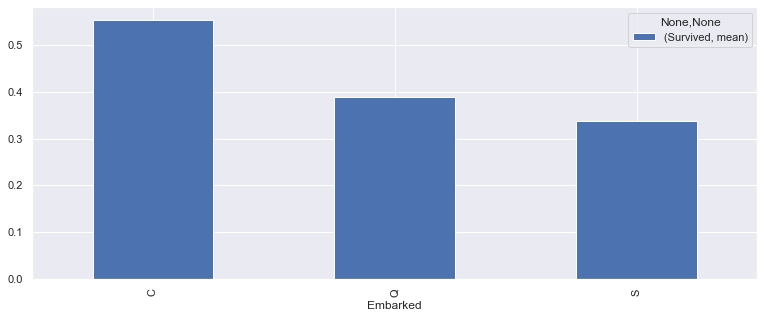

In [25]:
train[['Embarked','Survived']].groupby(['Embarked']).agg({'mean', 'count'})
train[['Embarked','Survived']].groupby(['Embarked']).agg({'mean'}).plot.bar()

C:\Users\never\Miniconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\never\Miniconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Survived          
                   count      mean
Embarked Pclass                   
C        1            85  0.694118
         2            17  0.529412
         3            66  0.378788
Q        1             2  0.500000
         2             3  0.666667
         3            72  0.375000
S        1           127  0.582677
         2           164  0.463415
         3           353  0.189802

<AxesSubplot:xlabel='Embarked,Pclass'>

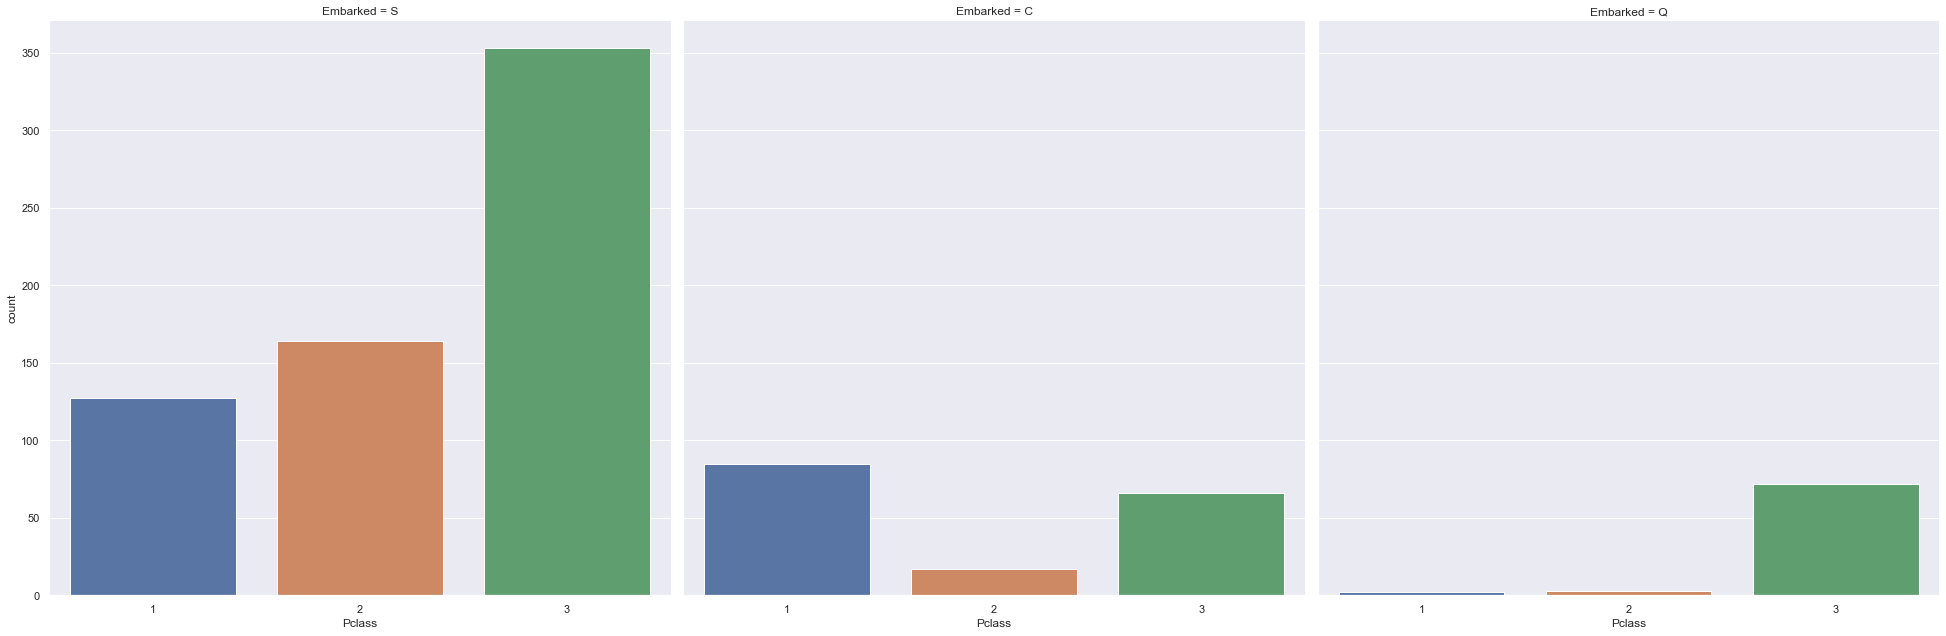

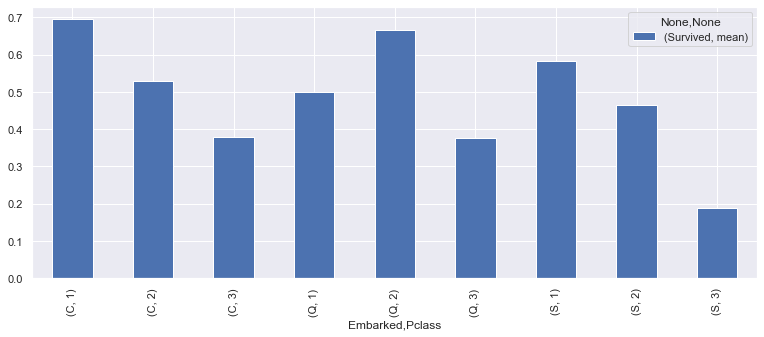

In [26]:
# 从pclass角度可以解释， C地上船的头等舱占比更多
sns.factorplot('Pclass',col='Embarked',data=train,kind='count',size=9)
train[['Embarked','Pclass','Survived']].groupby(['Embarked','Pclass']).agg({'mean','count'})
train[['Embarked','Pclass','Survived']].groupby(['Embarked','Pclass']).agg({'mean'}).plot.bar()

## 12. Cabin_num VS Survived
Cabin缺失值过多，缺失值的存活率只有0.29  
跟其他类别有明显的差距，所以如果要填缺失值，不能单独看cabin填充，需要结合其他变量一起考虑  
B D E的存活率较高，但是缺失值那么多，这个结论不一定完全适用于test上

<AxesSubplot:xlabel='Cabin_num', ylabel='Survived'>

Survived          
             count      mean
Cabin_num                   
A               15  0.466667
B               47  0.744681
C               59  0.593220
D               33  0.757576
E               32  0.750000
F               13  0.615385
G                4  0.500000
T                1  0.000000
n              687  0.299854

<AxesSubplot:xlabel='Cabin_num'>

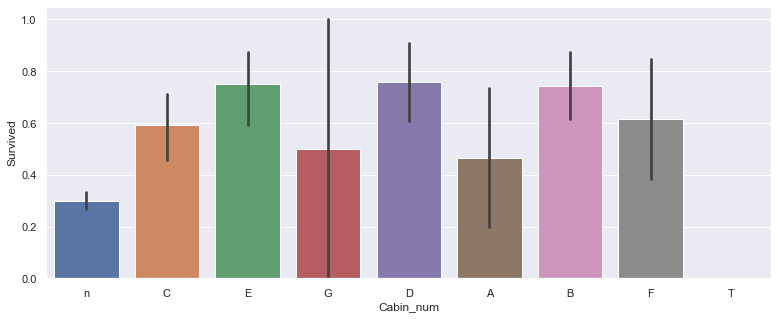

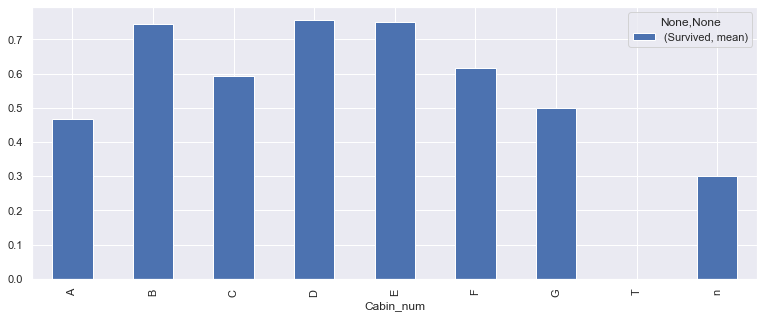

In [27]:
sns.barplot(data=train,x='Cabin_num',y='Survived')
train[['Cabin_num','Survived']].groupby(['Cabin_num']).agg({'mean','count'})
train[['Cabin_num','Survived']].groupby(['Cabin_num']).agg({'mean'}).plot.bar()

## 13. Title VS Survived
Mr和officer的存活率较低  
其他都超过基准了

<AxesSubplot:xlabel='Title', ylabel='Survived'>

Survived          
           count      mean
Title                     
Master        40  0.575000
Miss         184  0.701087
Mr           517  0.156673
Mrs          127  0.795276
Officer       18  0.277778
Royalty        4  0.500000

<AxesSubplot:xlabel='Title'>

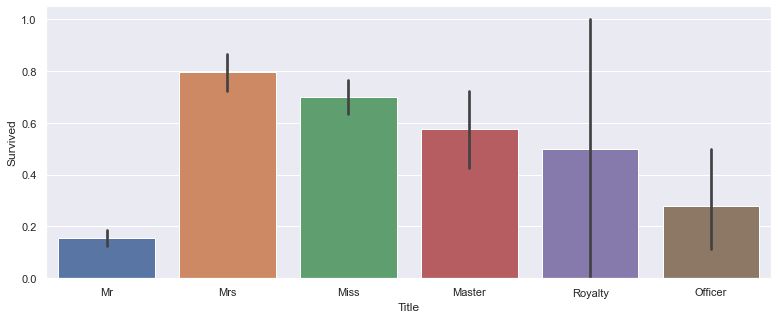

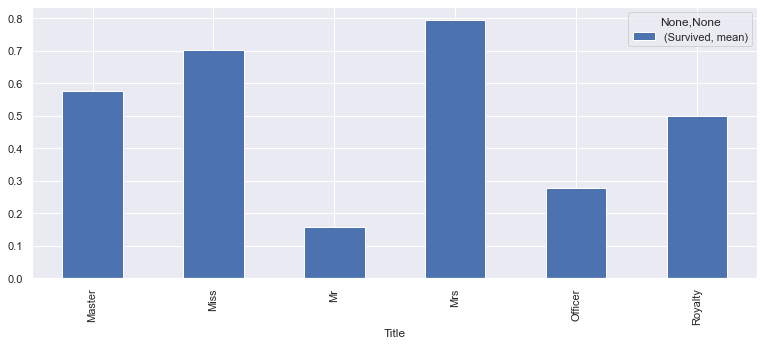

In [28]:
sns.barplot(data=train,x='Title',y='Survived')
train[['Title','Survived']].groupby(['Title']).agg({'mean','count'})
train[['Title','Survived']].groupby(['Title']).agg({'mean'}).plot.bar()

## 14. 相关性矩阵
单纯的相关性矩阵，得到的信息不是很多，都在上面的分析中涉及到了

<AxesSubplot:>

Text(0.5, 1.0, 'Pearson Correlation between original trianset')

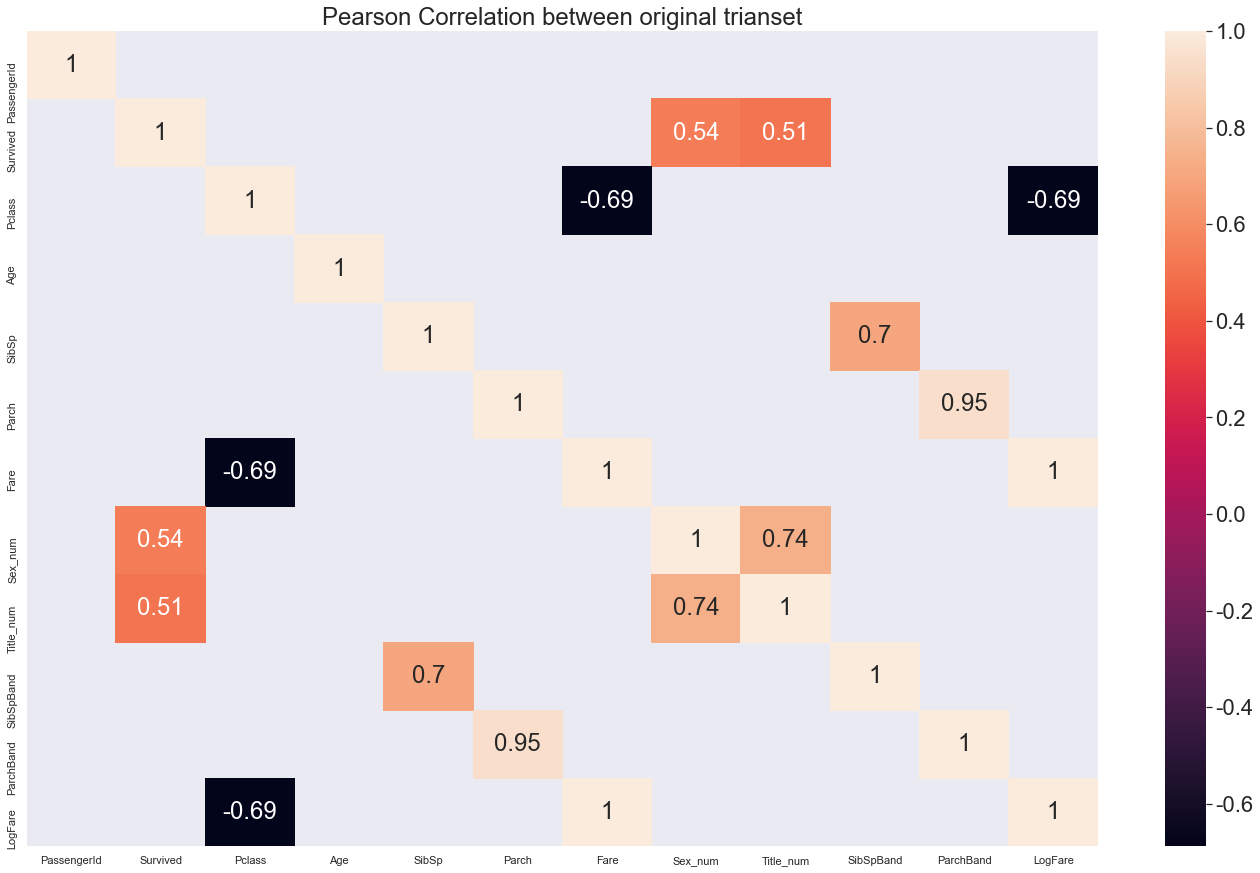

In [29]:
f, ax= plt.subplots(figsize = (24, 15))
sns.set(font_scale=2)
sns.heatmap(train.corr('spearman'), mask=(train.corr('spearman') < 0.5) & (train.corr('spearman') >-0.5), annot=True)
ax.set_title('Pearson Correlation between original trianset')

## 写在后面
这里只是简单对变量之间做了一些探索，但是可以发现明显有些特征的结合效果是超过原始特征的

# 五、参考资料
[Kaggle泰坦尼克号生存模型——250个特征量的融合模型，排名8%](https://zhuanlan.zhihu.com/p/30538352)  
[Kaggle平台Titanic生存率预测项目(TOP3%)](https://zhuanlan.zhihu.com/p/50194676)  
[Kaggle titanic 讨论区](https://www.kaggle.com/c/titanic/discussion?sort=top)    
    
    
    